In [ ]:
pip install -r requirements.txt

  Using cached torch-2.7.1-cp313-cp313-win_amd64.whl.metadata (28 kB)
  Using cached ptflops-0.7.4-py3-none-any.whl.metadata (9.4 kB)
  Using cached numpy-2.3.2-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pillow-11.3.0-cp313-cp313-win_amd64.whl.metadata (9.2 kB)
  Using cached scikit_learn-1.7.1-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.14.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pandas-2.3.1-cp313-cp313-win_amd64.whl.m

In [2]:
pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
import time
from tqdm import tqdm
import torchvision.models as models
from ptflops import get_model_complexity_info
from sklearn.metrics import accuracy_score

In [5]:
# Function to get image paths and labels
def get_image_paths_and_labels(data_path):
    """Gathering image paths and labels with proper label encoding."""
    image_paths = []
    labels = []
    categories = sorted(os.listdir(data_path))  # Ensure consistent ordering
    
    for category in categories:
        category_path = os.path.join(data_path, category)
        if os.path.isdir(category_path):
            images = os.listdir(category_path)
            if not images:
                print(f"Warning: No images found in {category_path}")
                continue  # Skip empty folders
            for img_name in images:
                img_path = os.path.join(category_path, img_name)
                image_paths.append(img_path)
                labels.append(category)
    
    print(f"Found {len(image_paths)} images across {len(categories)} categories.")
    
    # Convert labels to numerical values
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)  # Encodes labels into numbers
    return image_paths, labels, categories, label_encoder

In [6]:
# Custom Dataset Class
class CustomImageDataset(Dataset):
    """
    A custom dataset class for loading images and their corresponding labels.
    
    Args:
        image_paths (list): List of file paths to the images.
        labels (list): List of labels corresponding to the images.
        transform (callable, optional): Optional transform to be applied on a sample.
    """
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths  # List of image file paths
        self.labels = labels  # Corresponding labels
        self.transform = transform  # Optional image transformations

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Retrieves an image and its corresponding label at the specified index.
        Args:
            idx (int): Index of the sample to retrieve.
        Returns:
            tuple: (image, label) where image is a transformed image tensor and label is a tensor.
        """
        img_path = self.image_paths[idx] # Get image path
        
        try:
            # Load the image and convert it to RGB format
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image: {img_path}, Error: {e}")
            return None  # Graceful handling of image loading errors
        
        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Convert label to a tensor (ensure it's in the correct format for training)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

In [7]:
# Training and testing functions

def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    """
    Trains the ResNet-50 model.

    Args:
    - model (nn.Module): The ResNet-50 model.
    - train_loader (DataLoader): Training dataset loader.
    - criterion (loss function): Loss function (e.g., CrossEntropyLoss).
    - optimizer (torch.optim): Optimizer (e.g., Adam, SGD).
    - device (torch.device): Device (CPU/GPU).
    - epochs (int): Number of training epochs.
    """
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")
        losses.append(running_loss/len(train_loader))
    return losses

def evaluate_model(model, test_loader, criterion, device, class_names):
    """
    Evaluates the ResNet-50 model on the test dataset and prints the classification report and confusion matrix.

    Args:
    - model (nn.Module): The ResNet-50 model.
    - test_loader (DataLoader): Test dataset loader.
    - criterion (loss function): Loss function (e.g., CrossEntropyLoss).
    - device (torch.device): Device (CPU/GPU).
    - class_names (list): List of class names for labels.
    """
    model.eval()
    test_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print(f"Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


In [8]:
def get_pretrained_model(device, name='resnet50', num_classes=21):
    if name == 'resnet50':
        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        unfrozen = model.fc
    elif name == 'densenet121':
        model = models.densenet121(pretrained=True)
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
        unfrozen = model.classifier
    elif name == 'mobilenet_v2':
        model = models.quantization.mobilenet_v2(pretrained=True, quantize=False)

        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        unfrozen = model.classifier
    else:
        raise ValueError("Unsupported model")

    for param in model.parameters():
        param.requires_grad = False
    for param in unfrozen.parameters():
        param.requires_grad = True

    return model.to(device)


Step1: Getting the image paths and labels...
Found 2100 images across 21 categories.
Step2: Splitting the images and labels into training and test datasets...
Step3: Initiating custom dataset class for both traing and testing dataset...
Step4: Initiating dataloader for both traing and testing dataset...
Loading pretrained resnet50 model and fine-tuning it...


c:\Users\debli\OneDrive\Desktop\CNNProject\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\debli\OneDrive\Desktop\CNNProject\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Defining loss function and optimizer...
Model: resnet50 training started...


Epoch [1/20], Loss: 2.9059, Accuracy: 11.02%


Epoch [2/20], Loss: 2.5859, Accuracy: 40.34%


Epoch [3/20], Loss: 2.3086, Accuracy: 63.81%


Epoch [4/20], Loss: 2.0633, Accuracy: 74.76%


Epoch [5/20], Loss: 1.8461, Accuracy: 81.29%


Epoch [6/20], Loss: 1.6713, Accuracy: 84.29%


Epoch [7/20], Loss: 1.5173, Accuracy: 86.87%


Epoch [8/20], Loss: 1.3783, Accuracy: 89.80%


Epoch [9/20], Loss: 1.2773, Accuracy: 90.14%


Epoch [10/20], Loss: 1.1666, Accuracy: 91.77%


Epoch [11/20], Loss: 1.0851, Accuracy: 91.36%


Epoch [12/20], Loss: 1.0152, Accuracy: 92.86%


Epoch [13/20], Loss: 0.9529, Accuracy: 92.04%


Epoch [14/20], Loss: 0.8890, Accuracy: 93.40%


Epoch [15/20], Loss: 0.8227, Accuracy: 94.49%


Epoch [16/20], Loss: 0.7832, Accuracy: 92.99%


Epoch [17/20], Loss: 0.7501, Accuracy: 93.67%


Epoch [18/20], Loss: 0.7092, Accuracy: 93.61%


Epoch [19/20], Loss: 0.6756, Accuracy: 94.97%


Epoch [20/20], Loss: 0.6372, Accuracy: 94.90%


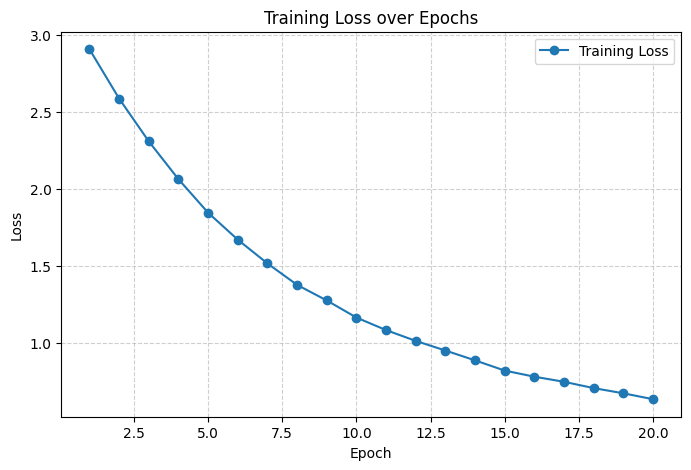

Model: resnet50 is being evaluated on the test dataset...
Test Loss: 0.6615, Accuracy: 92.06%

Classification Report:
                   precision    recall  f1-score   support

     agricultural       0.93      1.00      0.97        28
         airplane       1.00      0.97      0.99        40
  baseballdiamond       0.88      0.85      0.87        27
            beach       1.00      1.00      1.00        30
        buildings       0.62      0.87      0.73        23
        chaparral       1.00      0.92      0.96        26
 denseresidential       0.81      0.77      0.79        22
           forest       0.95      1.00      0.97        36
          freeway       1.00      0.94      0.97        32
       golfcourse       0.95      0.90      0.92        39
           harbor       1.00      0.97      0.99        37
     intersection       0.83      0.89      0.86        28
mediumresidential       0.76      0.79      0.77        28
   mobilehomepark       0.94      0.91      0.93       

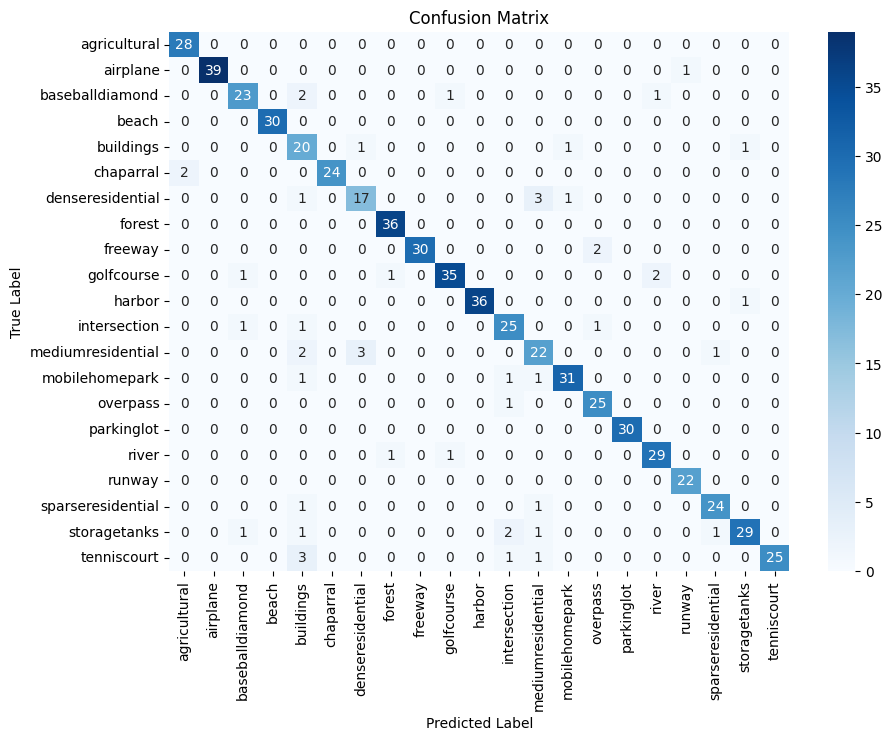

Loading pretrained densenet121 model and fine-tuning it...


c:\Users\debli\OneDrive\Desktop\CNNProject\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\debli\OneDrive\Desktop\CNNProject\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Defining loss function and optimizer...
Model: densenet121 training started...


Epoch [1/20], Loss: 3.1135, Accuracy: 4.35%


Epoch [2/20], Loss: 2.9072, Accuracy: 10.61%


Epoch [3/20], Loss: 2.7352, Accuracy: 19.93%


Epoch [4/20], Loss: 2.5682, Accuracy: 32.31%


Epoch [5/20], Loss: 2.4180, Accuracy: 46.19%


Epoch [6/20], Loss: 2.2712, Accuracy: 55.65%


Epoch [7/20], Loss: 2.1344, Accuracy: 61.16%


Epoch [8/20], Loss: 2.0093, Accuracy: 69.80%


Epoch [9/20], Loss: 1.8857, Accuracy: 74.29%


Epoch [10/20], Loss: 1.7829, Accuracy: 78.91%


Epoch [11/20], Loss: 1.6846, Accuracy: 79.52%


Epoch [12/20], Loss: 1.5879, Accuracy: 83.27%


Epoch [13/20], Loss: 1.5035, Accuracy: 84.29%


Epoch [14/20], Loss: 1.4201, Accuracy: 85.85%


Epoch [15/20], Loss: 1.3554, Accuracy: 87.28%


Epoch [16/20], Loss: 1.2998, Accuracy: 87.48%


Epoch [17/20], Loss: 1.2344, Accuracy: 87.89%


Epoch [18/20], Loss: 1.1801, Accuracy: 88.37%


Epoch [19/20], Loss: 1.1163, Accuracy: 90.14%


Epoch [20/20], Loss: 1.0732, Accuracy: 90.54%


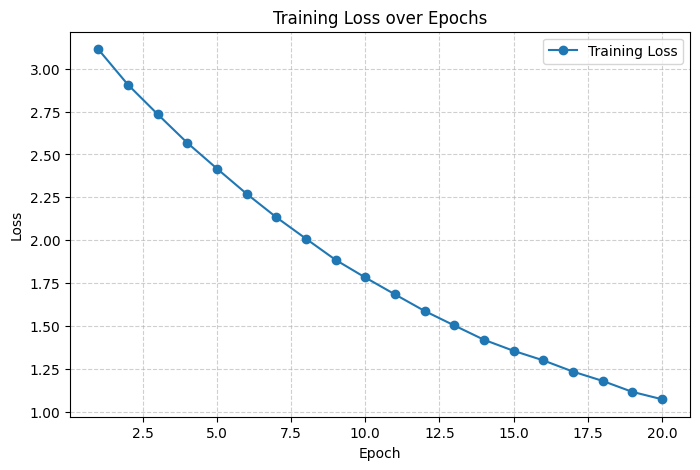

Model: densenet121 is being evaluated on the test dataset...
Test Loss: 1.0802, Accuracy: 88.73%

Classification Report:
                   precision    recall  f1-score   support

     agricultural       1.00      1.00      1.00        28
         airplane       1.00      1.00      1.00        40
  baseballdiamond       0.88      0.81      0.85        27
            beach       0.94      1.00      0.97        30
        buildings       0.61      0.87      0.71        23
        chaparral       1.00      1.00      1.00        26
 denseresidential       0.63      0.55      0.59        22
           forest       0.87      0.94      0.91        36
          freeway       1.00      0.84      0.92        32
       golfcourse       0.86      0.82      0.84        39
           harbor       1.00      1.00      1.00        37
     intersection       0.89      0.86      0.87        28
mediumresidential       0.61      0.71      0.66        28
   mobilehomepark       0.88      0.85      0.87    

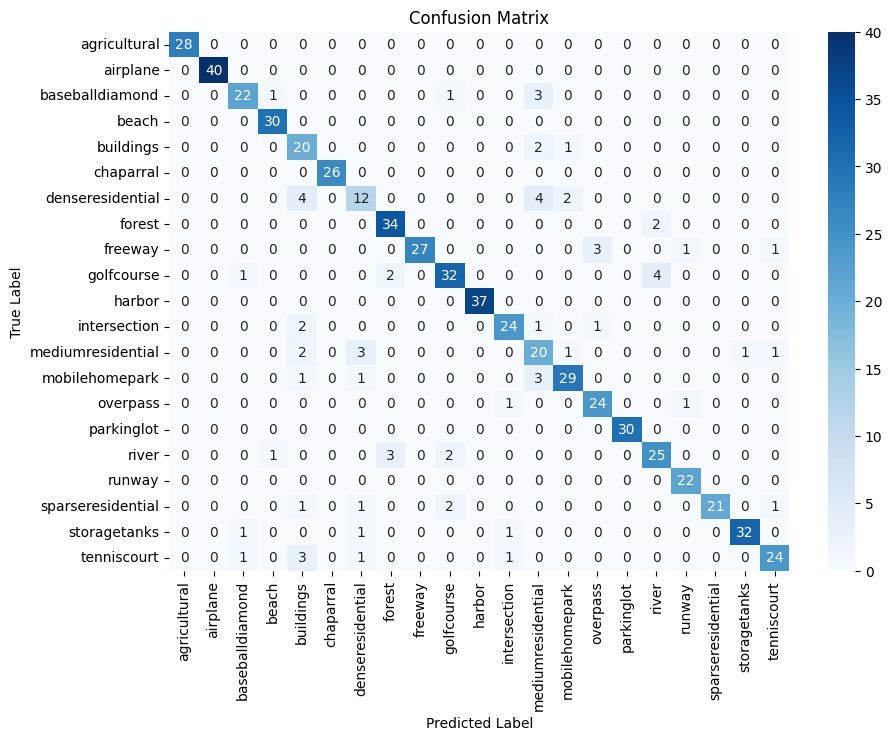

c:\Users\debli\OneDrive\Desktop\CNNProject\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\debli\OneDrive\Desktop\CNNProject\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading pretrained mobilenet_v2 model and fine-tuning it...
Defining loss function and optimizer...
Model: mobilenet_v2 training started...


Epoch [1/20], Loss: 2.9705, Accuracy: 9.05%


Epoch [2/20], Loss: 2.6845, Accuracy: 23.74%


Epoch [3/20], Loss: 2.4389, Accuracy: 43.81%


Epoch [4/20], Loss: 2.2074, Accuracy: 55.58%


Epoch [5/20], Loss: 2.0103, Accuracy: 67.14%


Epoch [6/20], Loss: 1.8291, Accuracy: 72.79%


Epoch [7/20], Loss: 1.6730, Accuracy: 78.50%


Epoch [8/20], Loss: 1.5314, Accuracy: 81.16%


Epoch [9/20], Loss: 1.4105, Accuracy: 84.35%


Epoch [10/20], Loss: 1.3226, Accuracy: 84.22%


Epoch [11/20], Loss: 1.2224, Accuracy: 85.99%


Epoch [12/20], Loss: 1.1475, Accuracy: 88.64%


Epoch [13/20], Loss: 1.0793, Accuracy: 88.64%


Epoch [14/20], Loss: 1.0045, Accuracy: 89.93%


Epoch [15/20], Loss: 0.9479, Accuracy: 90.61%


Epoch [16/20], Loss: 0.8897, Accuracy: 91.02%


Epoch [17/20], Loss: 0.8545, Accuracy: 90.68%


Epoch [18/20], Loss: 0.8053, Accuracy: 91.36%


Epoch [19/20], Loss: 0.7638, Accuracy: 92.38%


Epoch [20/20], Loss: 0.7340, Accuracy: 91.97%


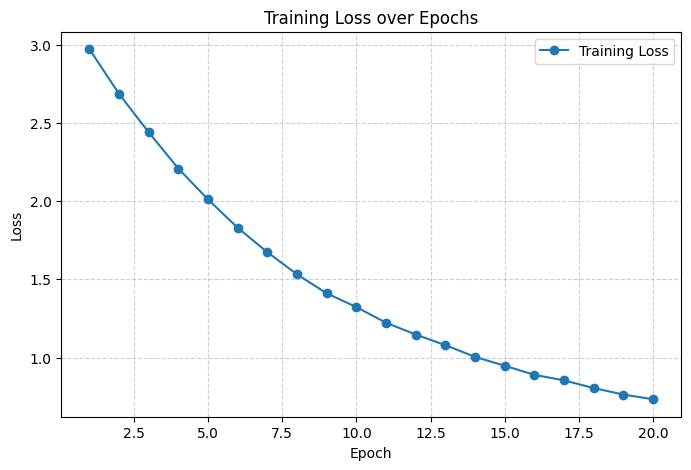

Model: mobilenet_v2 is being evaluated on the test dataset...
Test Loss: 0.7551, Accuracy: 90.32%

Classification Report:
                   precision    recall  f1-score   support

     agricultural       0.97      1.00      0.98        28
         airplane       0.97      0.90      0.94        40
  baseballdiamond       0.89      0.89      0.89        27
            beach       1.00      1.00      1.00        30
        buildings       0.65      0.96      0.77        23
        chaparral       1.00      0.96      0.98        26
 denseresidential       0.80      0.73      0.76        22
           forest       0.95      0.97      0.96        36
          freeway       0.86      1.00      0.93        32
       golfcourse       0.97      0.82      0.89        39
           harbor       1.00      1.00      1.00        37
     intersection       0.81      0.79      0.80        28
mediumresidential       0.77      0.71      0.74        28
   mobilehomepark       0.91      0.88      0.90   

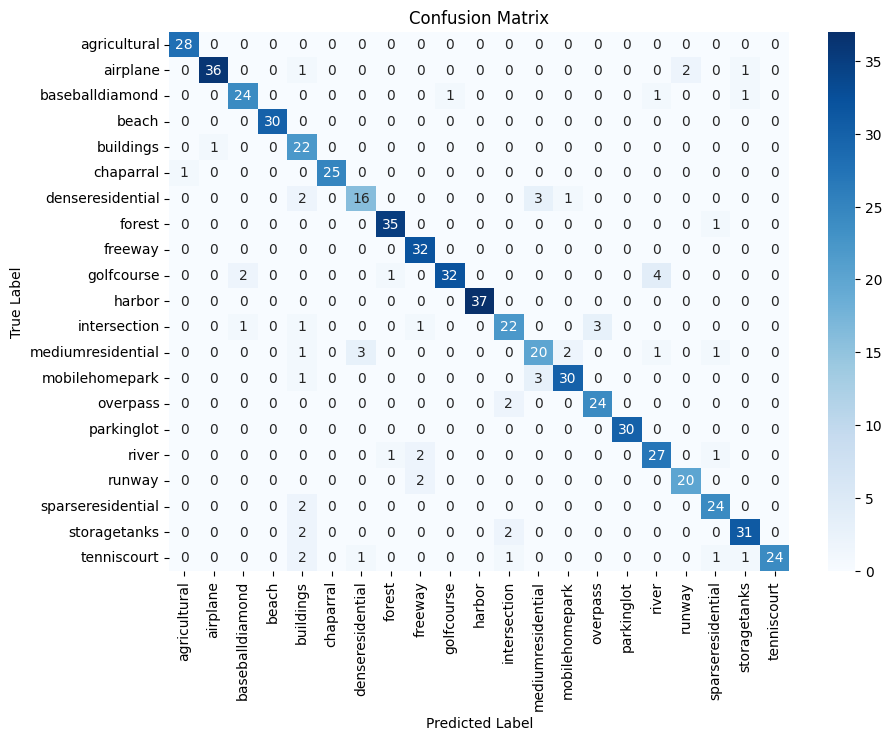

In [32]:
# Main execution

if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define transformations
    transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet-50 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    data_path = r"C:\Users\debli\Downloads\My_data\UCMerced_LandUse"

    # Get image paths and labels
    print("Step1: Getting the image paths and labels...")
    image_paths, labels, categories, label_encoder = get_image_paths_and_labels(data_path)

    # Split data into training and test sets (70% train, 30% test)
    print("Step2: Splitting the images and labels into training and test datasets...")
    features_train, features_test, labels_train, labels_test = train_test_split(image_paths, labels, test_size=0.3, random_state=101)

    # Load dataset
    print("Step3: Initiating custom dataset class for both traing and testing dataset...")
    train_dataset = CustomImageDataset(features_train, labels_train, transform=transform)
    test_dataset = CustomImageDataset(features_test, labels_test, transform=transform)
    
    print("Step4: Initiating dataloader for both traing and testing dataset...")
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Load pretrained CNN models and fine-tune
    for model_name in ['resnet50', 'densenet121','mobilenet_v2']:
        print(f"Loading pretrained {model_name} model and fine-tuning it...")
        model = get_pretrained_model(device, model_name, num_classes=21)


        # Define loss function & optimizer
        print("Defining loss function and optimizer...")
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)

        # Train and evaluate model
        print(f"Model: {model_name} training started...")
        losses = train_model(model, train_loader, criterion, optimizer, device, epochs=20)

        # After training loop
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, len(losses)+1), losses, marker='o', label='Training Loss')
        plt.title("Training Loss over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        plt.show()

        print(f"Model: {model_name} is being evaluated on the test dataset...")
        evaluate_model(model, test_loader, criterion, device, categories)
        torch.save(model.state_dict(), rf"C:\Users\debli\OneDrive\Desktop\CNNProject\models\{model_name}_ucmerced.pth")

In [33]:
# Define model loader
def load_finetuned_model(model_name, weight_path, device, num_classes=21):
    if model_name == 'resnet50':
        model = models.resnet50(pretrained=False)
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'densenet121':
        model = models.densenet121(pretrained=False)
        model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)
    elif model_name == 'mobilenet_v2':
        model = models.quantization.mobilenet_v2(pretrained=True, quantize=False)
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError("Unsupported model name.")

    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [34]:
def count_parameters(model):
    return sum(
        t.numel() for t in model.state_dict().values()
        if isinstance(t, torch.Tensor)
    )

In [35]:
# Benchmarking utility
def benchmark_model(model, model_name, test_loader, device):
    # 1. Accuracy
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)

    # 2. Latency (average over 100 runs)
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    torch.cuda.synchronize() if device.type == 'cuda' else None
    start = time.time()
    with torch.no_grad():
        for _ in range(100):
            _ = model(dummy_input)
    torch.cuda.synchronize() if device.type == 'cuda' else None
    latency_ms = (time.time() - start) / 100 * 1000

    # 3. FLOPs & Params using ptflops
    try:
        with torch.cuda.device(0 if device.type == 'cuda' else -1):
            flops, _ = get_model_complexity_info(model, (3, 224, 224), print_per_layer_stat=False, as_strings=True)
    except:
        flops = "N/A"

    # 4. Parameters (custom for quantized models)
    params = count_parameters(model)
    params_str = f"{params/1e6:.2f} M"  # format in millions

    # Summary
    return {
        "Model": model_name,
        "Accuracy": round(acc * 100, 2),
        "Latency (ms/sample)": round(latency_ms, 2),
        "Parameters": params_str,
        "FLOPs": flops
    }

In [36]:
# Main comparison
def run_benchmarks(model_dir, device, test_loader):
    model_names = ['resnet50', 'densenet121', 'mobilenet_v2']
    summary = []

    for name in model_names:
        print(f"\n📦 Loading {name}...")
        weight_path = os.path.join(model_dir, f"{name}_ucmerced.pth")
        model = load_finetuned_model(name, weight_path, device)
        print(f"📊 Benchmarking {name}...")
        result = benchmark_model(model, name, test_loader, device)
        summary.append(result)

    return summary


In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison(df):
    # Copy and set index
    df_plot = df.copy()
    df_plot.set_index("Model", inplace=True)
    
    # Extract values
    models = df_plot.index
    accuracy = df_plot["Accuracy"]
    latency = df_plot["Latency (ms/sample)"]

    # Create figure
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()  # Second axis for latency

    # Pastel colors (consistent)
    acc_color = "#A3C9F1"  # pastel blue
    lat_color = "#F9C7A0"  # pastel orange

    bar_width = 0.4
    x = np.arange(len(models))

    # Accuracy bars (left y-axis)
    acc_bars = ax1.bar(x - bar_width/2, accuracy, bar_width,
                       label='Accuracy (%)', color=acc_color, edgecolor='black', linewidth=0.5)
    # Latency bars (right y-axis)
    lat_bars = ax2.bar(x + bar_width/2, latency, bar_width,
                       label='Latency (ms/sample)', color=lat_color, edgecolor='black', linewidth=0.5)

    # Add labels on bars
    for bar in acc_bars:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 f"{bar.get_height():.2f}%", ha='center', fontsize=10, fontweight='bold')
    for bar in lat_bars:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 f"{bar.get_height():.2f}", ha='center', fontsize=10, fontweight='bold')

    # Axis labels
    ax1.set_ylabel("Accuracy (%)", fontsize=12)
    ax2.set_ylabel("Latency (ms/sample)", fontsize=12)
    ax1.set_xlabel("Model", fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, fontsize=11, fontweight='bold')

    # Title
    plt.title("📊 Model Performance Comparison", fontsize=14, fontweight='bold', pad=15)

    # Grid only for accuracy axis
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Legend (combined from both axes)
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(handles1 + handles2, labels1 + labels2,
               loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=11)

    plt.tight_layout()
    plt.show()


📦 Loading resnet50...


c:\Users\debli\OneDrive\Desktop\CNNProject\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\debli\OneDrive\Desktop\CNNProject\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


📊 Benchmarking resnet50...

📦 Loading densenet121...
📊 Benchmarking densenet121...


c:\Users\debli\OneDrive\Desktop\CNNProject\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\debli\OneDrive\Desktop\CNNProject\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



📦 Loading mobilenet_v2...
📊 Benchmarking mobilenet_v2...


c:\Users\debli\OneDrive\Desktop\CNNProject\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\debli\OneDrive\Desktop\CNNProject\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


          Model  Accuracy  Latency (ms/sample) Parameters        FLOPs
0      resnet50     92.06               133.02    23.60 M    4.13 GMac
1   densenet121     88.73               193.55     7.06 M     2.9 GMac
2  mobilenet_v2     90.32                42.64     2.28 M  325.37 MMac


C:\Users\debli\AppData\Local\Temp\ipykernel_10760\1367610496.py:59: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\debli\OneDrive\Desktop\CNNProject\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


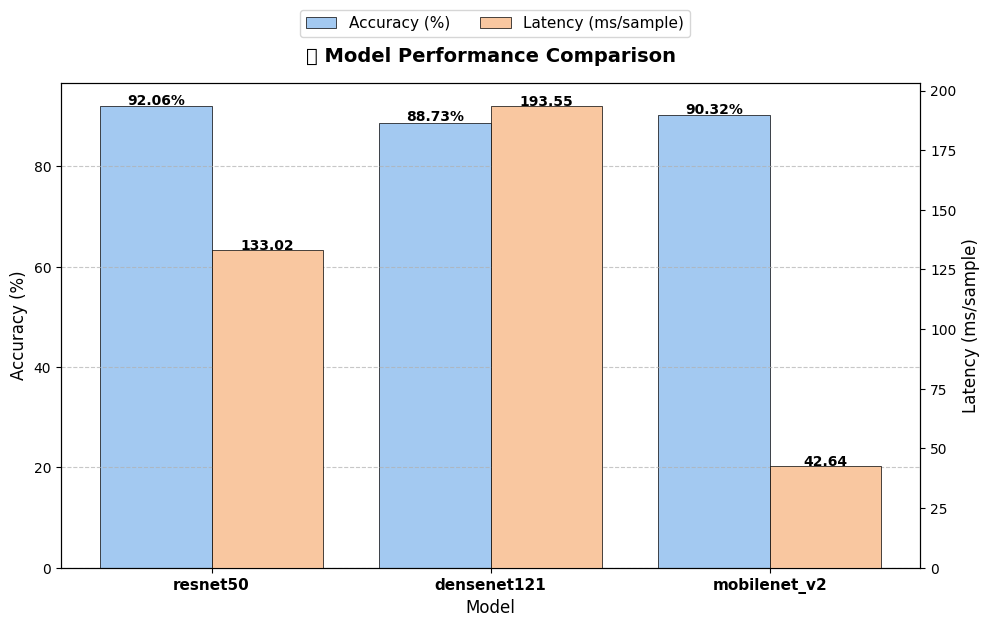

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = r"C:\Users\debli\OneDrive\Desktop\CNNProject\models"

results = run_benchmarks(model_dir, device, test_loader)

import pandas as pd
df = pd.DataFrame(results)
print(df)
plot_comparison(df)

In [39]:
import torch.quantization

def quantize_model(model, test_loader, device):
    model.eval()
    model.to('cpu')  # Static quantization must happen on CPU

    # Fuse layers specific to MobileNetV2
    model.fuse_model()  # Required for quantization; available in torchvision MobileNetV2

    # Set quantization config
    model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
    torch.quantization.prepare(model, inplace=True)

    # Calibration using test data
    with torch.no_grad():
        for images, _ in test_loader:
            model(images)

    # Convert to quantized model
    torch.quantization.convert(model, inplace=True)
    return model


In [40]:
def run_benchmarks2(model_dir, device, test_loader):
    model_names = ['mobilenet_v2']
    summary = []

    for name in model_names:
        print(f"\n📦 Loading {name}...")
        weight_path = os.path.join(model_dir, f"{name}_ucmerced.pth")
        model = load_finetuned_model(name, weight_path, device)
        print(f"📊 Benchmarking {name}...")
        result = benchmark_model(model, name, test_loader, device)
        summary.append(result)

    # Quantize MobileNetV2 and evaluate
    name = 'mobilenet_v2'
    print(f"\n⚡ Quantizing {name}...")
    weight_path = os.path.join(model_dir, f"{name}_ucmerced.pth")
    orig_model = load_finetuned_model(name, weight_path, device)
    quantized_model = quantize_model(orig_model, test_loader, device)
    torch.save(model.state_dict(), rf"C:\Users\debli\OneDrive\Desktop\CNNProject\models\{name}_quantized_ucmerced.pth")

    print(f"📊 Benchmarking quantized {name}...")
    quant_result = benchmark_model(quantized_model, f"{name}_quantized", test_loader, torch.device("cpu"))
    summary.append(quant_result)

    return summary



📦 Loading mobilenet_v2...


c:\Users\debli\OneDrive\Desktop\CNNProject\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\debli\OneDrive\Desktop\CNNProject\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📊 Benchmarking mobilenet_v2...

⚡ Quantizing mobilenet_v2...


c:\Users\debli\OneDrive\Desktop\CNNProject\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\debli\OneDrive\Desktop\CNNProject\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\debli\OneDrive\Desktop\CNNProject\venv\Lib\site-packages\torch\ao\quantization\observer.py:244: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
c:\Users\debli\OneDrive\Des

📊 Benchmarking quantized mobilenet_v2...
                    Model  Accuracy  Latency (ms/sample) Parameters  \
0            mobilenet_v2     90.32                50.39     2.28 M   
1  mobilenet_v2_quantized     87.14                24.47     2.21 M   

         FLOPs  
0  325.37 MMac  
1   62.72 KMac  


C:\Users\debli\AppData\Local\Temp\ipykernel_10760\1367610496.py:59: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\debli\OneDrive\Desktop\CNNProject\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


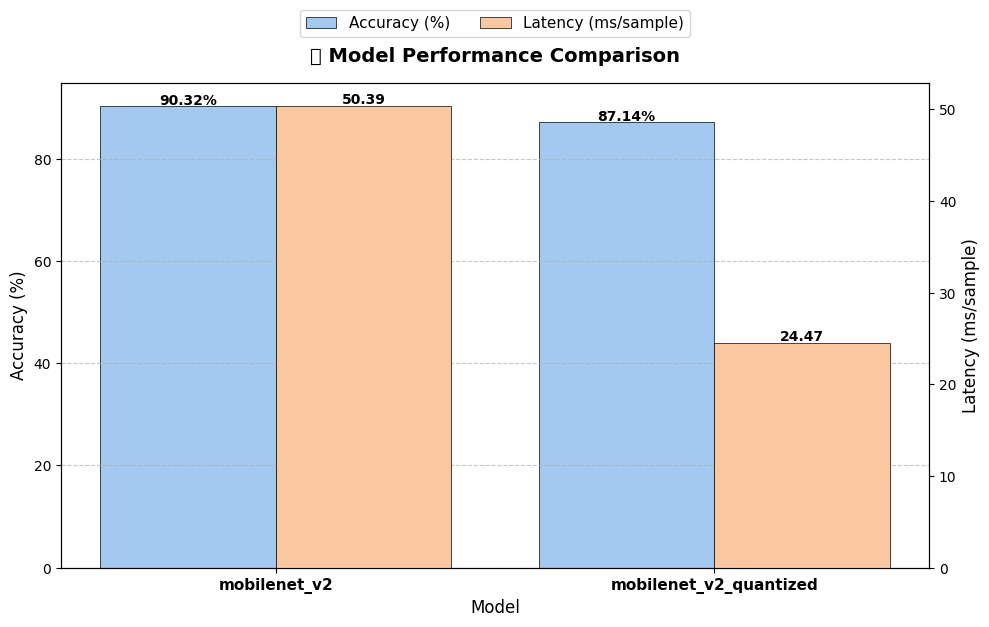

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = r"C:\Users\debli\OneDrive\Desktop\CNNProject\models"

results = run_benchmarks2(model_dir, device, test_loader)

import pandas as pd
df = pd.DataFrame(results)
print(df)
plot_comparison(df)